# Author

Name: Tobias Haider

Student id: 11833743



# Overview

This notebook demonstrates the process of loading, extracting and processing structured data about socer player attributes. The main subject of the experiment is the typical position of players with certain attributes. The goal is to gain insights on how certain physical features of soccer players affect there preference regarding their role in a professional soccer team.

# Preparation

## Import libraries

In [1]:
# data access
import sqlite3 as db
# data processing
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Define the access to the datasets

In [2]:
# sqlite file path
sqlite_path = "../data/soccer.sqlite"

# a function for executing database queries
def query_database(query):
    connection = db.connect(sqlite_path)
    dataframe = pd.read_sql_query(query, connection)
    connection.close()
    return dataframe

In [3]:
# define some queries for loading the data sets
sql_queries = {
    "countries": "select * from country",
    "leagues": "select * from league",
    "matches": "select * from match",
    "players": "select * from player",
    "player_attributes": "select * from player_attributes",
    "teams": "select * from team",
    "team_attributes": "select * from team_attributes"
}

def load_dataset(name):
    return query_database(sql_queries[name])

## Load the datasets

In [4]:
player_info = load_dataset("players").set_index("player_api_id")
player_attributes = load_dataset("player_attributes").set_index("player_api_id")
matches = load_dataset("matches")

# Preprocess the data

## Remove all historical player attributes

In [5]:
player_attributes = player_attributes[~player_attributes.index.duplicated(keep="last")]

## Evaluate the position of the players using the matches data

In [6]:
def extract_player_position(matches, method=pd.Series.mode):
    match_positions = pd.DataFrame(columns=["player_api_id", "position_X", "position_Y"])
    for i in range(1, 12):
        # extract the home player position
        home = matches[[f"home_player_{i}", f"home_player_X{i}", f"home_player_Y{i}"]]
        home = home.rename(columns={f"home_player_{i}": "player_api_id", f"home_player_X{i}": "position_X", f"home_player_Y{i}": "position_Y"})

        # extract the away player position
        away = matches[[f"away_player_{i}", f"away_player_X{i}", f"away_player_Y{i}"]]
        away = away.rename(columns={f"away_player_{i}": "player_api_id", f"away_player_X{i}": "position_X", f"away_player_Y{i}": "position_Y"})

        # add the positions to the new data frame
        match_positions = pd.concat([match_positions, home, away])
        
    player_positions = match_positions.groupby(["player_api_id"], as_index=True).agg({"position_X":"mean","position_Y":method})
    # take the first position if multiple are present
    player_positions["position_X"] = [pos.item(0) if isinstance(pos, np.ndarray) else pos for pos in player_positions["position_X"]]
    player_positions["position_Y"] = [pos.item(0) if isinstance(pos, np.ndarray) else pos for pos in player_positions["position_Y"]]
    
    return player_positions

In [7]:
player_positions = extract_player_position(matches, pd.Series.mode)

## Join all tables into one working dataset

In [8]:
players = player_info.join(player_attributes, lsuffix="player_info", rsuffix="player_attributes").join(player_positions, lsuffix="players", rsuffix="player_positions")
players = players[[c for c in players.columns if not "id" in c]]

## Map string to numeric variables

In [9]:
work_rate_mappings = {"low": 1, "medium": 2, "high": 3}
players.loc[~players["defensive_work_rate"].isin(work_rate_mappings), "defensive_work_rate"] = None
players["defensive_work_rate"] = players["defensive_work_rate"].map(work_rate_mappings)
players.loc[~players["attacking_work_rate"].isin(work_rate_mappings), "attacking_work_rate"] = None
players["attacking_work_rate"] = players["attacking_work_rate"].map(work_rate_mappings)

In [10]:
foot_mappings = {"left": 1, "right": 2}
players["preferred_foot"] = players["preferred_foot"].map(foot_mappings)

## Delete entries with missing values

In [11]:
players = players.dropna()

# Display the data

In [12]:
players

,player_name,birthday,height,weight,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,penalties,marking,standing_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,position_X,position_Y
player_api_id,,,,,,,,,,,,,,,,,,,,,
505942.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,2.0,2.0,2.0,...,47.0,62.0,63.0,5.0,10.0,9.0,7.0,7.0,5.500000,3.0
155782.0,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,2007-02-22 00:00:00,53.0,60.0,2.0,2.0,2.0,...,29.0,53.0,45.0,6.0,22.0,49.0,22.0,22.0,7.933333,3.0
162549.0,Aaron Doran,1991-05-13 00:00:00,170.18,163,2007-02-22 00:00:00,59.0,70.0,2.0,2.0,2.0,...,36.0,21.0,21.0,8.0,21.0,54.0,21.0,21.0,4.682692,7.0
30572.0,Aaron Galindo,1982-05-08 00:00:00,182.88,198,2007-02-22 00:00:00,71.0,78.0,2.0,2.0,3.0,...,60.0,72.0,70.0,14.0,11.0,58.0,11.0,10.0,5.500000,3.0
23780.0,Aaron Hughes,1979-11-08 00:00:00,182.88,154,2007-02-22 00:00:00,75.0,75.0,2.0,2.0,2.0,...,81.0,74.0,79.0,12.0,11.0,55.0,10.0,6.0,4.481481,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192132.0,Zouhaier Dhaouadhi,1988-01-01 00:00:00,180.34,159,2007-02-22 00:00:00,64.0,66.0,1.0,2.0,2.0,...,76.0,39.0,26.0,16.0,10.0,12.0,8.0,8.0,8.000000,7.0
282473.0,Zouhair Feddal,1989-01-01 00:00:00,190.50,172,2007-02-22 00:00:00,62.0,66.0,1.0,1.0,2.0,...,34.0,66.0,70.0,13.0,14.0,12.0,10.0,8.0,6.212766,3.0
26357.0,Zoumana Camara,1979-04-03 00:00:00,182.88,168,2007-02-22 00:00:00,77.0,78.0,2.0,1.0,2.0,...,68.0,83.0,76.0,14.0,13.0,73.0,13.0,6.0,5.205882,3.0


In [13]:
players["role"] = "other"
players.loc[players["position_Y"] > 8, "role"] = "front"
players.loc[(players["position_Y"] > 3) & (players["position_Y"] <= 8), "role"] = "middle"
players.loc[(players["position_Y"] > 1) & (players["position_Y"] <= 3), "role"] = "back"
players.loc[players["position_Y"] <= 1, "role"] = "goalkeeper"


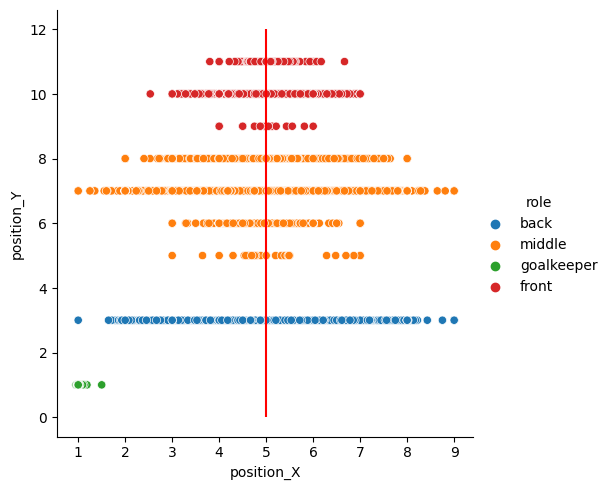

In [14]:
sns.relplot(data=players, x="position_X", y="position_Y", hue="role")
plt.vlines(5, 0, 12, colors="r")

<AxesSubplot: xlabel='height', ylabel='Count'>

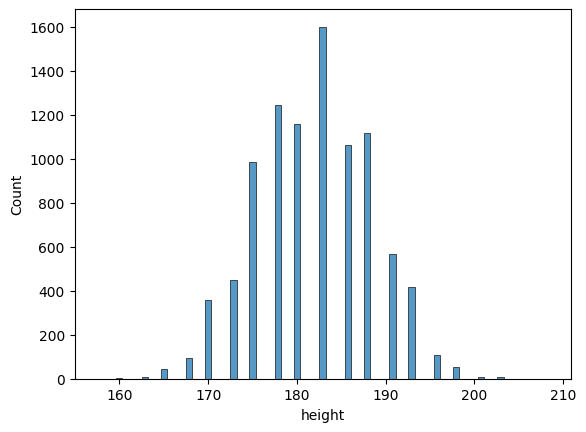

In [15]:
sns.histplot(data=players, x="height")

<AxesSubplot: xlabel='height', ylabel='Density'>

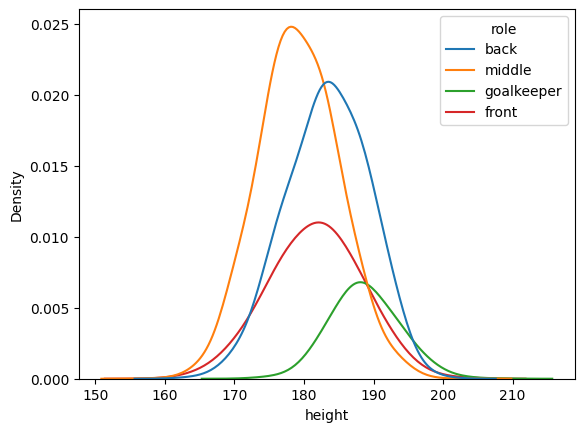

In [16]:
sns.kdeplot(data=players, x="height", hue="role", bw_adjust=2)

# Build a role predictor

In [17]:
random_state = 11833743

## Choose the features

In [18]:
X = players.drop(["player_name", "birthday", "date", "position_X", "position_Y", "role"], axis=1)
y = players["role"]
labels = y.unique()

## Create the train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## Create a support vector classifier

In [20]:
def train_svc(X, y, random_state=random_state):
    pipeline = Pipeline([
        ("scale", StandardScaler()),
        ("classify", SVC(random_state=random_state))])
    return pipeline.fit(X_train, y_train)

# train the svc
svc_model = train_svc(X_train, y_train)

In [21]:
y_pred = svc_model.predict(X_test)
classification_table = confusion_matrix(y_pred, y_test, labels=y.unique())

for label, accuracy in zip(labels, np.diag(classification_table) / np.sum(classification_table, axis=1)):
    print(f"SVC accuracy {label}: {accuracy}")
print(f"SVC accuracy total: {np.sum(np.diag(classification_table) / np.sum(np.sum(classification_table)))}")

SVC accuracy back: 0.8685258964143426
SVC accuracy middle: 0.7534136546184739
SVC accuracy goalkeeper: 0.996078431372549
SVC accuracy front: 0.7651245551601423
SVC accuracy total: 0.8134377038486627


## Create a lda classifer

In [23]:
def train_lda(X, y, random_state=random_state):
    pipeline = Pipeline([
        ("scale", StandardScaler()),
        ("classify", LinearDiscriminantAnalysis())])
    return pipeline.fit(X_train, y_train)

# train the svc
lda_model = train_lda(X_train, y_train)

In [24]:
y_pred = lda_model.predict(X_test)
classification_table = confusion_matrix(y_pred, y_test, labels=y.unique())

for label, accuracy in zip(labels, np.diag(classification_table) / np.sum(classification_table, axis=1)):
    print(f"LDA accuracy {label}: {accuracy}")
print(f"LDA accuracy total: {np.sum(np.diag(classification_table) / np.sum(np.sum(classification_table)))}")

LDA accuracy back: 0.8534396809571286
LDA accuracy middle: 0.7449152542372881
LDA accuracy goalkeeper: 0.9921875
LDA accuracy front: 0.7256778309409888
LDA accuracy total: 0.7971298108284409
